**Groups:**
+ *ecoli_HOGs_fullid_all* - all hierarchical orthologous groups (HOGs) with full id (**22356** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_all -g HOG --full_HOG --incl-nonPP**
    
+ *ecoli_HOGs_fullid_PP* - hierarchical orthologous groups (HOGs) with full id including only those containing at least 1 protein with polyproline motif (**6923** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_fullid_PP -g HOG --full_HOG**
    
+ *ecoli_HOGs_partid_all* - hierarchical orthologous groups (HOGs) with partial id ncluding only those containing at least 1 protein with polyproline motif (**7700** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_partid_all -g HOG --incl-nonPP**
    
+ *ecoli_HOGs_partid_PP* - all hierarchical orthologous groups (HOGs) with partial id (less similarity among proteins in group, paralogs are present) (**2328** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_HOGs_partid_PP -g HOG**
    
+ *ecoli_OMAs_all* - all OMA groups (**12441** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_OMAs_all -g OMA --incl-nonPP --oma-groups oma-groups.txt**
    
+ *ecoli_OMAs_PP* - OMA groups  including only those containing at least 1 protein with polyproline motif (**3894** groups)

    Command: **python extract_hogs.py -i ecoli_full_data/* -o ecoli_OMAs_PP -g OMA --oma-groups oma-groups.txt**

In [159]:
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import AlignIO
from Bio import pairwise2, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.AlignInfo import SummaryInfo
import os
import re
import seaborn as sns
from itertools import combinations
from collections import Counter, defaultdict
from statistics import median, mean
import pandas as pd
pd.set_option("display.max_rows", 100)

## Parsing

In [160]:
groups_list = ["ecoli_HOGs_fullid_all", "ecoli_HOGs_fullid_PP", "ecoli_HOGs_partid_all", "ecoli_HOGs_partid_PP", "ecoli_OMAs_all", "ecoli_OMAs_PP"]

def get_group_data(path):
    data_groups = defaultdict(list)
    data_motifs = defaultdict(list)
    for filename in os.listdir(path):
        parser = SeqIO.parse(os.path.join(path, filename), "fasta")
        for p_idx, r in enumerate(parser):
            try:
                prot_id, taxid, hog, motifs = r.description.split(" | ")
            except ValueError:
                (prot_id, taxid, hog), motifs = r.description.split(" | "), "NNNNN:0:0:N"

            motifs = motifs.split()
            data_groups["prot_id"].append(prot_id.strip("| "))
            data_groups["taxid"].append(taxid.strip("| "))
            data_groups["hog"].append(hog.strip("| "))
            for m_idx, motif in enumerate(motifs):
                seq, _, _, strength = motif.split(":")
                data_motifs["prot_id"].append(prot_id.strip("| "))
                data_motifs["strength"].append(strength.strip("| "))
                data_motifs["seq"].append(seq.strip("| "))
                #data["motif_num"].append(m_idx)
                #data["prot_num"].append(p_idx)
    data_groups = pd.DataFrame(data_groups)
    data_motifs = pd.DataFrame(data_motifs)
    return data_groups, data_motifs

## Group composition

ecoli_HOGs_fullid_all
Total number of groups:  22356
Groups with 1 protein - 13438
Groups with 43 proteins (core proteome) - 2232
Groups with < 43 proteins (accessory proteome) - 20124
Groups with > 43 proteins (paralogs included) - 0
Total number of paralogs - 0
Median of paralogs - 0.0
Mean of paralogs - 0.0

ecoli_HOGs_fullid_PP
Total number of groups:  6923
Groups with 1 protein - 4321
Groups with 43 proteins (core proteome) - 737
Groups with < 43 proteins (accessory proteome) - 6186
Groups with > 43 proteins (paralogs included) - 0
Total number of paralogs - 0
Median of paralogs - 0.0
Mean of paralogs - 0.0

ecoli_HOGs_partid_all
Total number of groups:  7700
Groups with 1 protein - 1269
Groups with 43 proteins (core proteome) - 1778
Groups with < 43 proteins (accessory proteome) - 5922
Groups with > 43 proteins (paralogs included) - 834
Total number of paralogs - 63195
Median of paralogs - 0.0
Mean of paralogs - 8.207142857142857

ecoli_HOGs_partid_PP
Total number of groups:  232

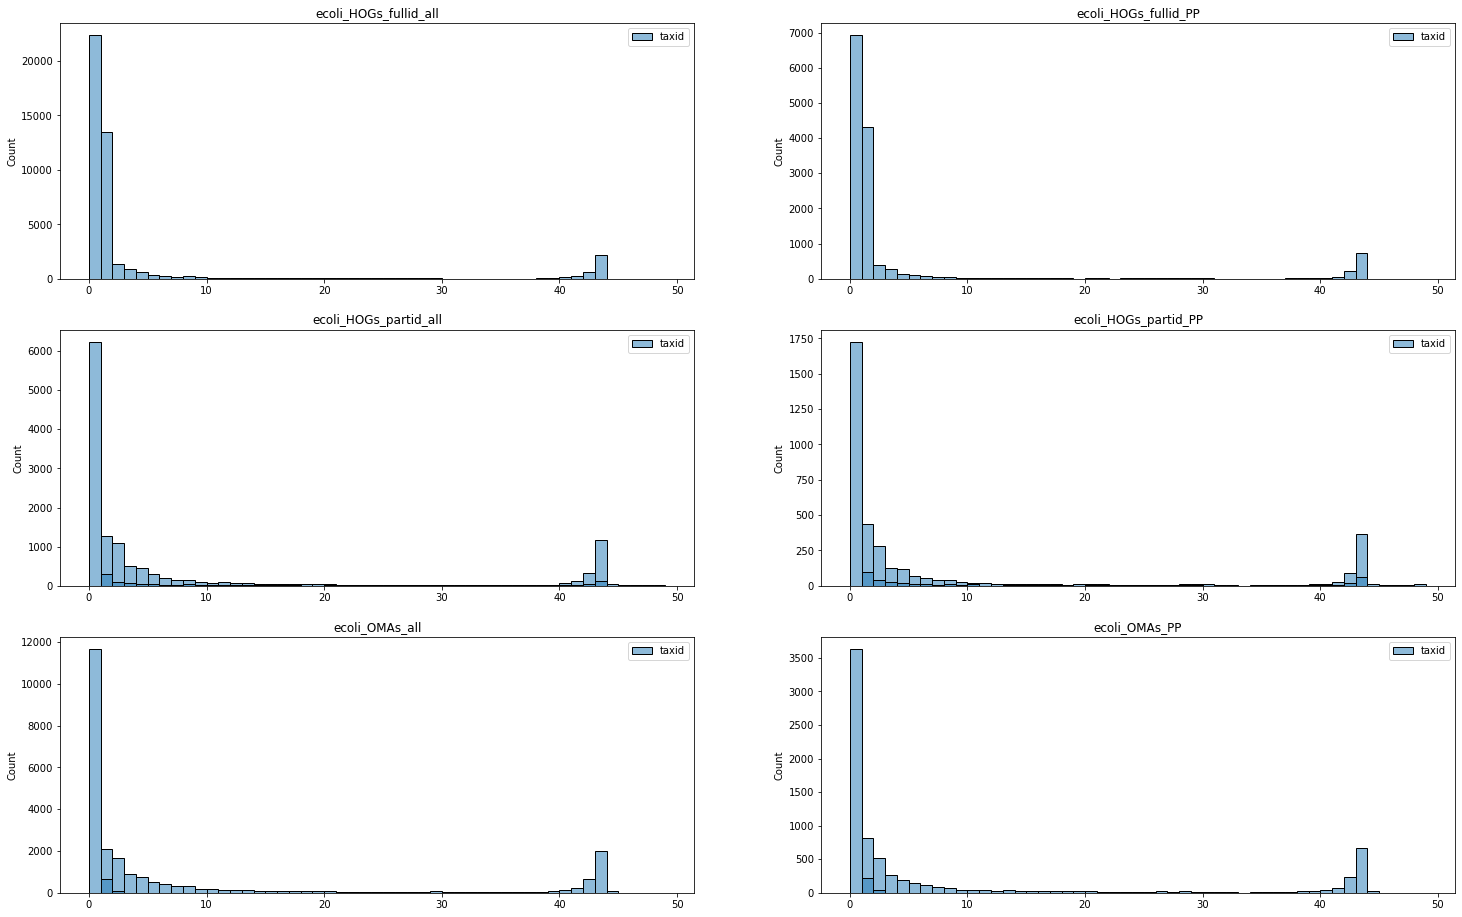

In [161]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    print(group)
    data_g, data_m = get_group_data(group)
    prot_count = data_g.groupby("hog").agg({"prot_id": lambda x: x.nunique()})
    paralog_count = data_g.groupby("hog").agg({"taxid": lambda x: x.size - x.nunique()})
    taxid_count = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()})
 
    print("Total number of groups: ", data_g.hog.nunique())
    print("Groups with 1 protein -", (prot_count.query("prot_id == 1").size))
    print("Groups with 43 proteins (core proteome) -", taxid_count.query("taxid == 43").size)
    print("Groups with < 43 proteins (accessory proteome) -", taxid_count.query("taxid < 43").size)
    print("Groups with > 43 proteins (paralogs included) -", prot_count.query("prot_id > 43").size)
    print("Total number of paralogs -", paralog_count.taxid.sum())
    print("Median of paralogs -", paralog_count.taxid.median())
    print("Mean of paralogs -", paralog_count.taxid.mean())
    print()
          
    sns.histplot(prot_count, bins=range(0, 50), ax=ax, alpha=0.5)
    sns.histplot(paralog_count, bins=range(0, 50), ax=ax, alpha=0.5)
    ax.set_title(group)

Distribution shows number of proteins in groups. Groups with partial HOG id (partid) may have more than 43 proteins, however axis is limited by 50.

**Dark color is number of paralogs**

## Proportion of proteins containing polyproline motifs

ecoli_HOGs_fullid_all
Average number of polyproline motifs per protein - 0.49393062856855396

ecoli_HOGs_fullid_PP
Average number of polyproline motifs per protein - 1.4772817823959712

ecoli_HOGs_partid_all
Average number of polyproline motifs per protein - 0.4939231744370888

ecoli_HOGs_partid_PP
Average number of polyproline motifs per protein - 1.088621790964722

ecoli_OMAs_all
Average number of polyproline motifs per protein - 0.4939231744370888

ecoli_OMAs_PP
Average number of polyproline motifs per protein - 1.4725283450312827



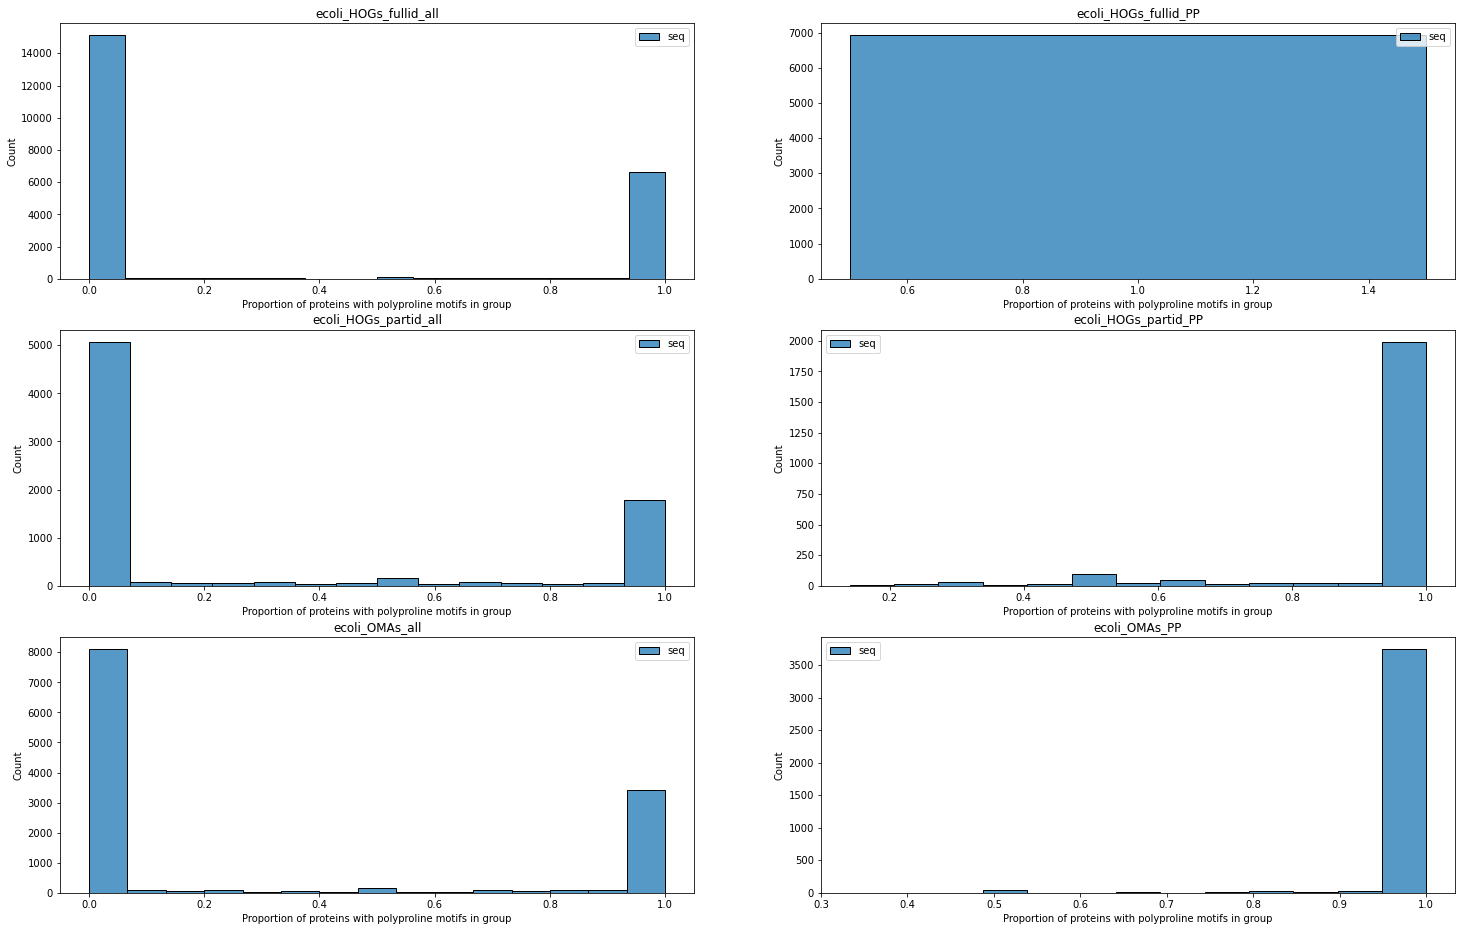

In [259]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    data_g, data_m = get_group_data(group)
    data = data_g.merge(data_m, on="prot_id")
    with_pp_count = data.groupby("hog").agg({"seq": lambda x: sum(x != "NNNNN") / x.size})
    pp_per_protein = data.groupby("prot_id").agg({"seq": lambda x: sum(x != "NNNNN")})
    print(group)
    print("Average number of polyproline motifs per protein -", pp_per_protein.seq.mean())
    print()
    sns.histplot(with_pp_count, ax=ax)
    ax.set_title(group)
    ax.set_xlabel("Proportion of proteins with polyproline motifs in group")

**ecoli_HOGs_fullid_PP** actually has proteins with no polyprolines, but there are few of them, so it is displayed like that.

## Motif strength distribution

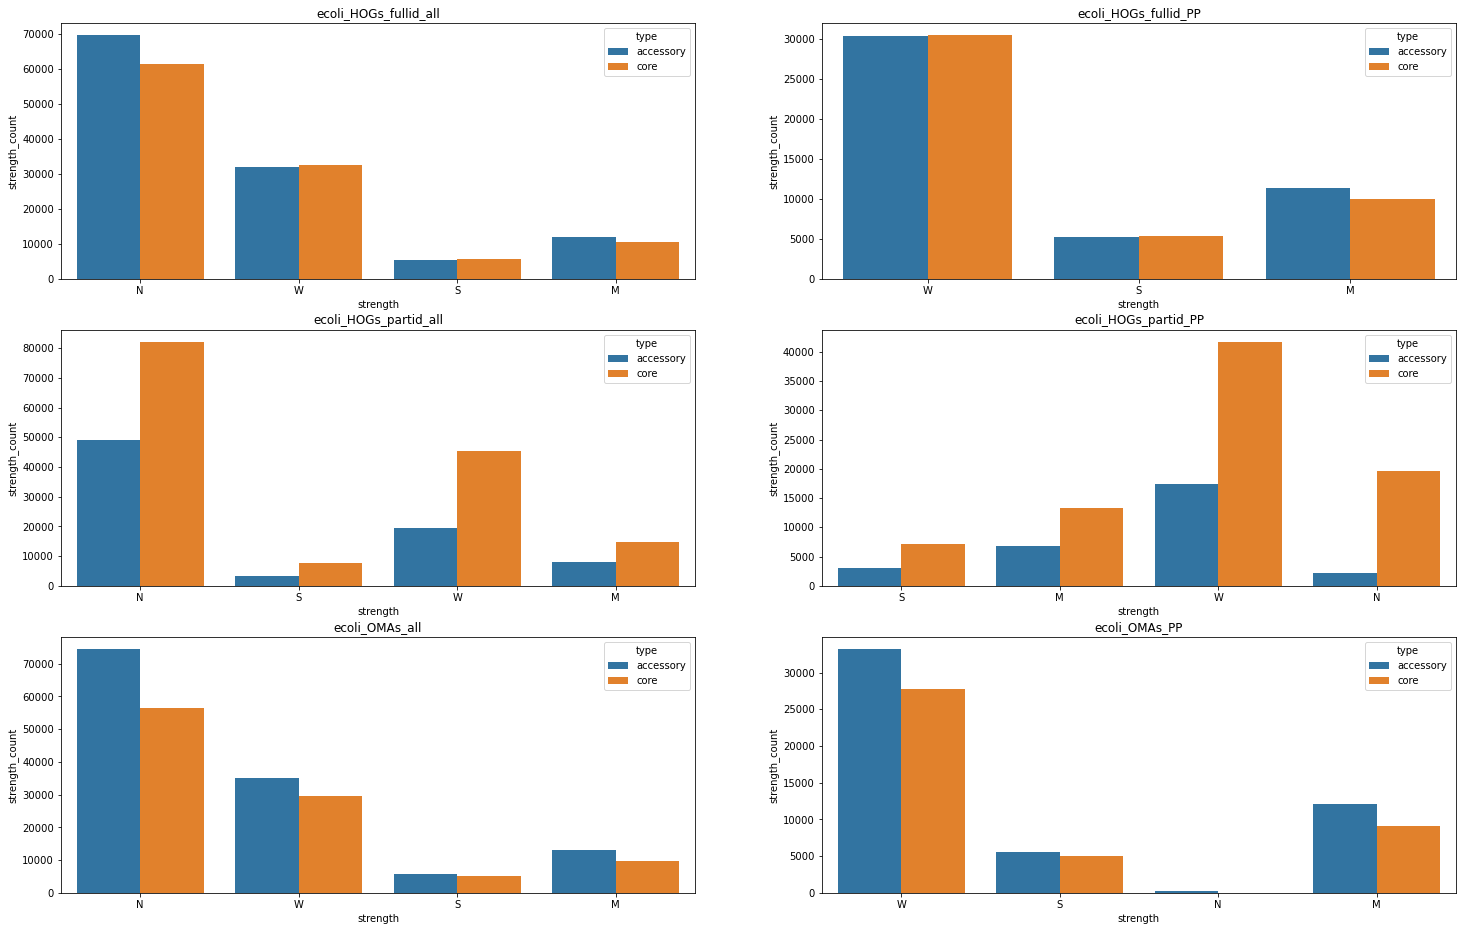

In [5]:
plt.rc("figure", figsize=(25, 16))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
for group, ax in zip(groups_list, [ax1, ax2, ax3, ax4, ax5, ax6]):
    data_g, data_m = get_group_data(group)
    data = data_g.merge(data_m, on="prot_id")
    core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
    accessory_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid < 43")
    accessory_proteome_groups.loc[:, "type"] = "accessory"
    core_proteome_groups.loc[:, "type"] = "core"
    data_types = data.merge(accessory_proteome_groups.append(core_proteome_groups).drop(columns=["taxid"]), on="hog", how="outer")
    strength_count = data_types.groupby(["strength", "type"]).agg({"prot_id": "count"})
    strength_count = strength_count.rename(columns={"prot_id": "strength_count"})
    data_types = data_types.merge(strength_count, on=["strength", "type"], how="outer")
    
    sns.barplot(x="strength", y="strength_count", hue="type", data=data_types, ax=ax)
    ax.set_title(group)

***N* is proteins without polyproline motifs**

# Multiple sequence alignment analysis

In [167]:
data_g, data_m = get_group_data("ecoli_HOGs_fullid_PP")

In [168]:
core_proteome_groups = data_g.groupby("hog").agg({"taxid": lambda x: x.nunique()}).query("taxid == 43")
target_groups = core_proteome_groups.index

In [171]:
group_motifs = defaultdict(list)
for hog in target_groups:
    motifs = set()
    # Select unique areas where motifs are aligned
    for rec in SeqIO.parse(f"alignment/ecoli_HOGs_fullid_PP/{hog.replace(':', '')}.fasta", "fasta"):
        all_motifs = rec.description.split(" | ")[3].split(" ")
        for motif in all_motifs:
            seq, _, _, strength = motif.split(":")
            match = re.search(seq, str(rec.seq))
            if not match:
                match = re.search(r'{}-*?{}-*?{}-*?{}-*?{}'.format(*seq), str(rec.seq))
            motifs.add(match.span())
    motif_data = [[] for _ in range(len(motifs))]
    # Extracting motifs info
    for rec in SeqIO.parse(f"alignment/ecoli_HOGs_fullid_PP/{hog.replace(':', '')}.fasta", "fasta"):
        seq = str(rec.seq)
        all_motifs = list(map(lambda x: x.split(":"), rec.description.split(" | ")[3].split(" ")))
        native_motifs = dict(zip(map(lambda x: x[0], all_motifs), map(lambda x: x[1:], all_motifs)))
        for idx, coords in enumerate(motifs):
            aligned_motif = seq[slice(*coords)]
            if (nm := aligned_motif.replace("-", "")) in native_motifs:
                motif_data[idx].append((aligned_motif, *coords, nm, *native_motifs[nm]))
            else:
                motif_data[idx].append((aligned_motif, *coords))
    motif_data = [pd.DataFrame(md, columns=["aligned_motif", "aligned_start", "aligned_end", "motif", "start", "end", "strength"][:len(md)]) for md in motif_data]
    for md in motif_data:
        group_motifs[hog].append(md)

In [260]:
total_PP = 0
total_motifs = 0 
for group in group_motifs:
    for md in group_motifs[group]:
        total_PP += sum(md.aligned_motif.apply(lambda x: "PP" in x.replace("-", ""))) / 43
        total_motifs += 1
print("Proportion of polyproline motifs in alignments -", total_PP / total_motifs)

Proportion of polyproline motifs in alignments - 0.9452310214117409


## Proline substitutions

In [173]:
def substitutions(msa):
    return dict(filter(lambda x: x[1] > 0, dict(zip(msa.substitutions.alphabet, msa.substitutions["P"])).items()))

all_substitutions = pd.Series(0, index=list("ACDEFGHIKLMNPQRSTVWY_"))
for group in group_motifs:
    for md in group_motifs[group]:
        msa = MultipleSeqAlignment(list(map(lambda x: SeqRecord(Seq(x.replace("-", "_"))), md.aligned_motif)))
        current_substitutions = pd.Series(substitutions(msa), index=list("ACDEFGHIKLMNPQRSTVWY_")).fillna(0)
        all_substitutions = all_substitutions.add(current_substitutions)
print("Overall substitutions of proline (not an absolute numbers!)")
print(all_substitutions)

Overall substitutions of proline (not an absolute numbers!)
A       1552.5
C         21.0
D         21.0
E        309.0
F         70.0
G         63.0
H         21.0
I          5.0
K        155.0
L       1650.0
M         21.0
N         28.0
P    2082300.0
Q       1876.5
R        108.0
S       4206.5
T       1068.0
V         21.0
W          0.0
Y          0.0
_       6042.0
dtype: float64


In [174]:
def percent_identity(seq1, seq2):
    matches = 0
    for s1, s2 in zip(seq1, seq2):
        if s1 == s2:
            matches += 1
    return matches / len(seq1) * 100


group_identities = []
for hog in target_groups:
    seq_identities = []
    records = list(SeqIO.parse(f"alignment/ecoli_HOGs_fullid_PP/{hog.replace(':', '')}.fasta", "fasta"))
    sequences = tuple(map(lambda x: x.seq, records))
    for seq_pair in combinations(sequences, 2):
        seq_identities.append(percent_identity(*seq_pair))
    group_identities.append(mean(seq_identities))

Text(0.5, 0, 'Mean pairwise identity, %')

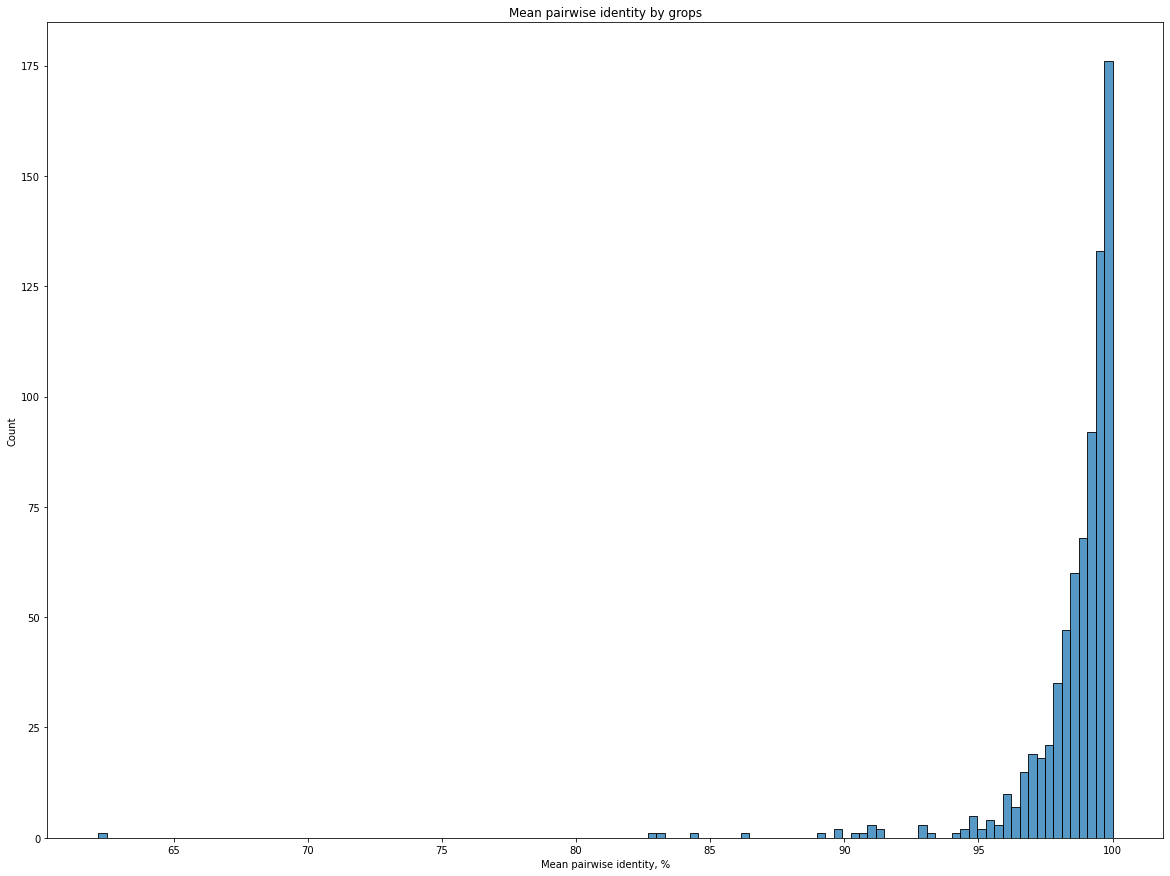

In [175]:
plt.rc("figure", figsize=(20, 15))
sns.histplot(group_identities)
plt.title("Mean pairwise identity by grops")
plt.xlabel("Mean pairwise identity, %")

In [266]:
all_insertion_lengths = []
for hog in group_motifs:
    for md in group_motifs[hog]:
        insertion_lengths = md.aligned_motif.apply(lambda x: x.count("-"))
        all_insertion_lengths.append(insertion_lengths[insertion_lengths > 0].mean())

## Insertion size distribution

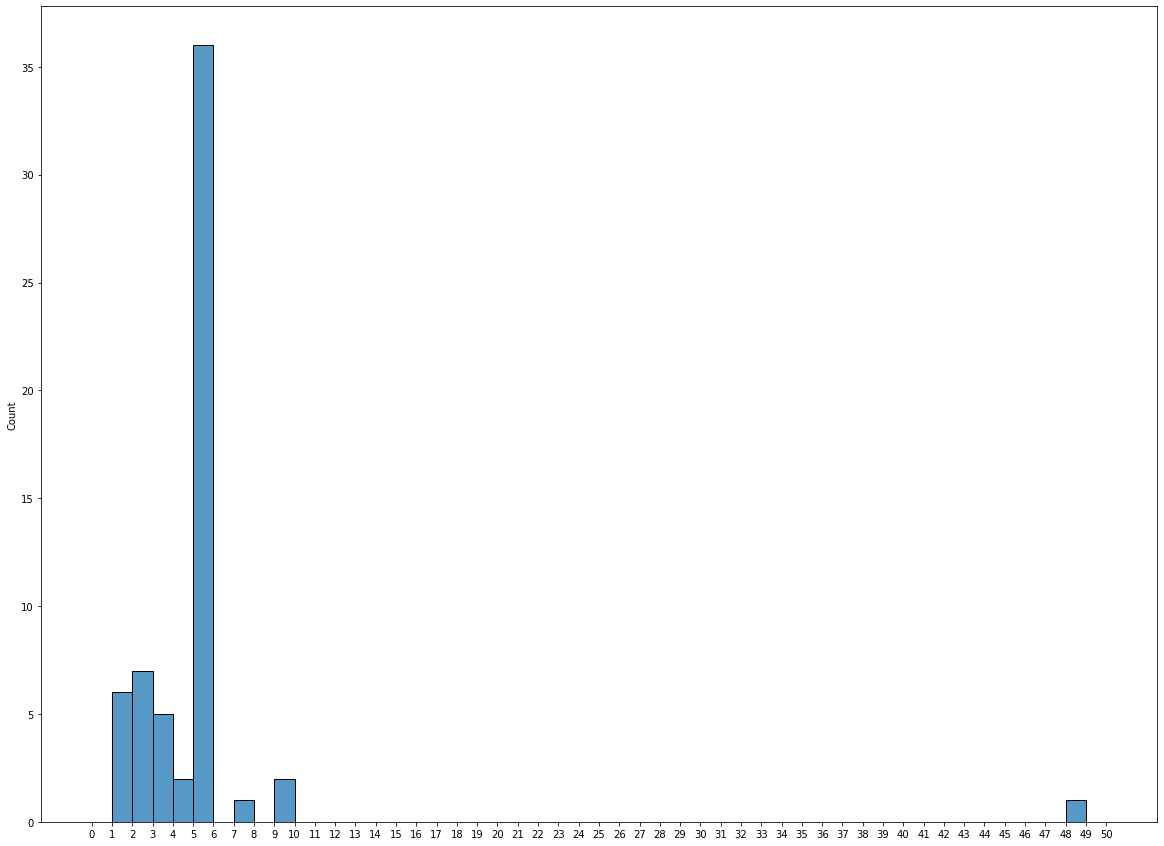

In [245]:
nan = float("nan")
insert_distrib = list(filter(lambda x: x != nan, all_insertion_lengths))
sns.histplot(all_insertion_lengths, bins=range(0, 51))
_ = plt.xticks(range(0, 51), range(0, 51))
